# Surface conductance parameters

In [7]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os
from shutil import copyfile
import warnings
warnings.filterwarnings('ignore')

This is a custom package specifically designed for this analysis. It contains various functions for reading and computing and plotting.

In [4]:
from gs_util import read_forcing,modify_attr,cal_gs_obs,IQR_compare,obs_sim,cal_gs_mod,gs_plot_test,modify_attr_2,func_parse_date

## Preparing the data (obs and model)

In [5]:
name='US-MMS' 
year=2017
df_forcing= read_forcing(name,year)

In [8]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
df_state_init,level=modify_attr(df_state_init,name)
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]
grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

2020-03-26 10:09:25,798 — SuPy — INFO — All cache cleared.
2020-03-26 10:09:26,642 — SuPy — INFO — All cache cleared.


## Spin up to get soil moisture

In [9]:
error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2020-03-26 10:09:34,245 — SuPy — INFO — ====================
2020-03-26 10:09:34,246 — SuPy — INFO — Simulation period:
2020-03-26 10:09:34,248 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-03-26 10:09:34,250 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-03-26 10:09:34,251 — SuPy — INFO — 
2020-03-26 10:09:34,253 — SuPy — INFO — No. of grids: 1
2020-03-26 10:09:34,254 — SuPy — INFO — SuPy is running in serial mode
2020-03-26 10:09:48,656 — SuPy — INFO — Execution time: 14.4 s
2020-03-26 10:09:48,656 — SuPy — INFO — ====================

933.0266258519457
2020-03-26 10:09:49,106 — SuPy — INFO — ====================
2020-03-26 10:09:49,107 — SuPy — INFO — Simulation period:
2020-03-26 10:09:49,107 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-03-26 10:09:49,108 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-03-26 10:09:49,109 — SuPy — INFO — 
2020-03-26 10:09:49,111 — SuPy — INFO — No. of grids: 1
2020-03-26 10:09:49,112 — SuPy — INFO — SuPy is running in serial mode
2020-03-2

## Preparation of the data for model optimization  

In [10]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()

In [11]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[df_forcing.qe > 0]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)
df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

In [12]:
g_max=np.percentile(gs_obs,99)
s1=5.56

In [13]:
print('Initial g_max is {}'.format(g_max))

Initial g_max is 33.023283412991034


In [14]:
df_forcing=df_forcing[gs_obs<g_max]
lai_max=df_state_init.laimax.loc[grid,:][1]
gs_obs=gs_obs[gs_obs<g_max]

### Distribution of observed $g_s$

Text(0, 0.5, '$g_s$')

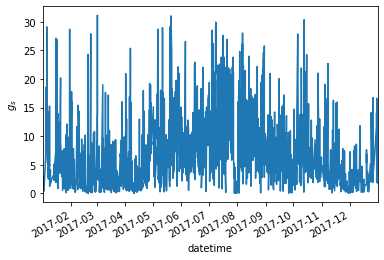

In [16]:
gs_obs.plot()
plt.ylabel('$g_s$')

In [17]:
print('lai_max is {}'.format(lai_max))

lai_max is 5.0


## Splitting the data to test and train

In [19]:
df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [20]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

## Optimization

More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

### Function to optimize

In [22]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

### Problem definition and run

In [27]:
problem = Problem(6,2,1)
problem.types[0] = Real(.09, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(0.02, 0.03)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
algorithm.run(3000)


### Solutions

In [28]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.073	0.555
0.112	0.545
0.161	0.534
0.056	0.560
0.003	0.579
0.092	0.550
0.199	0.530
0.133	0.540
0.026	0.570
0.014	0.575


Text(0, 0.5, 'objective 2')

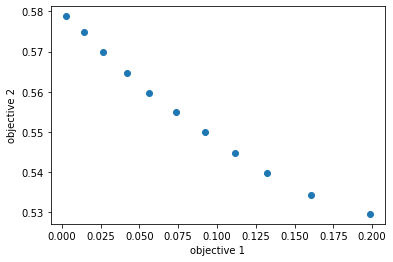

In [29]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

In [30]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

### Choosing between : the median of two objectives, where obj1 is max or where obj2 is max

In [31]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.07329333444496633
0.5549996145597578


In [32]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

### Saving the solution

In [33]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [34]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [35]:
pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
US-MMS,0.431,104.34,0.634,0.683,35.25,0.03


Let's see how the model and observation compare for the training data set:

Text(0, 0.5, '$g_s$')

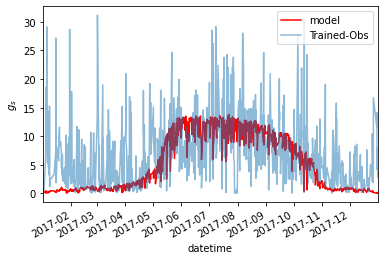

In [38]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r',label='model')
gs_train.plot(alpha=0.5,label='Trained-Obs')
plt.legend()
plt.ylabel('$g_s$')

Let's look at each individual $g$ term:

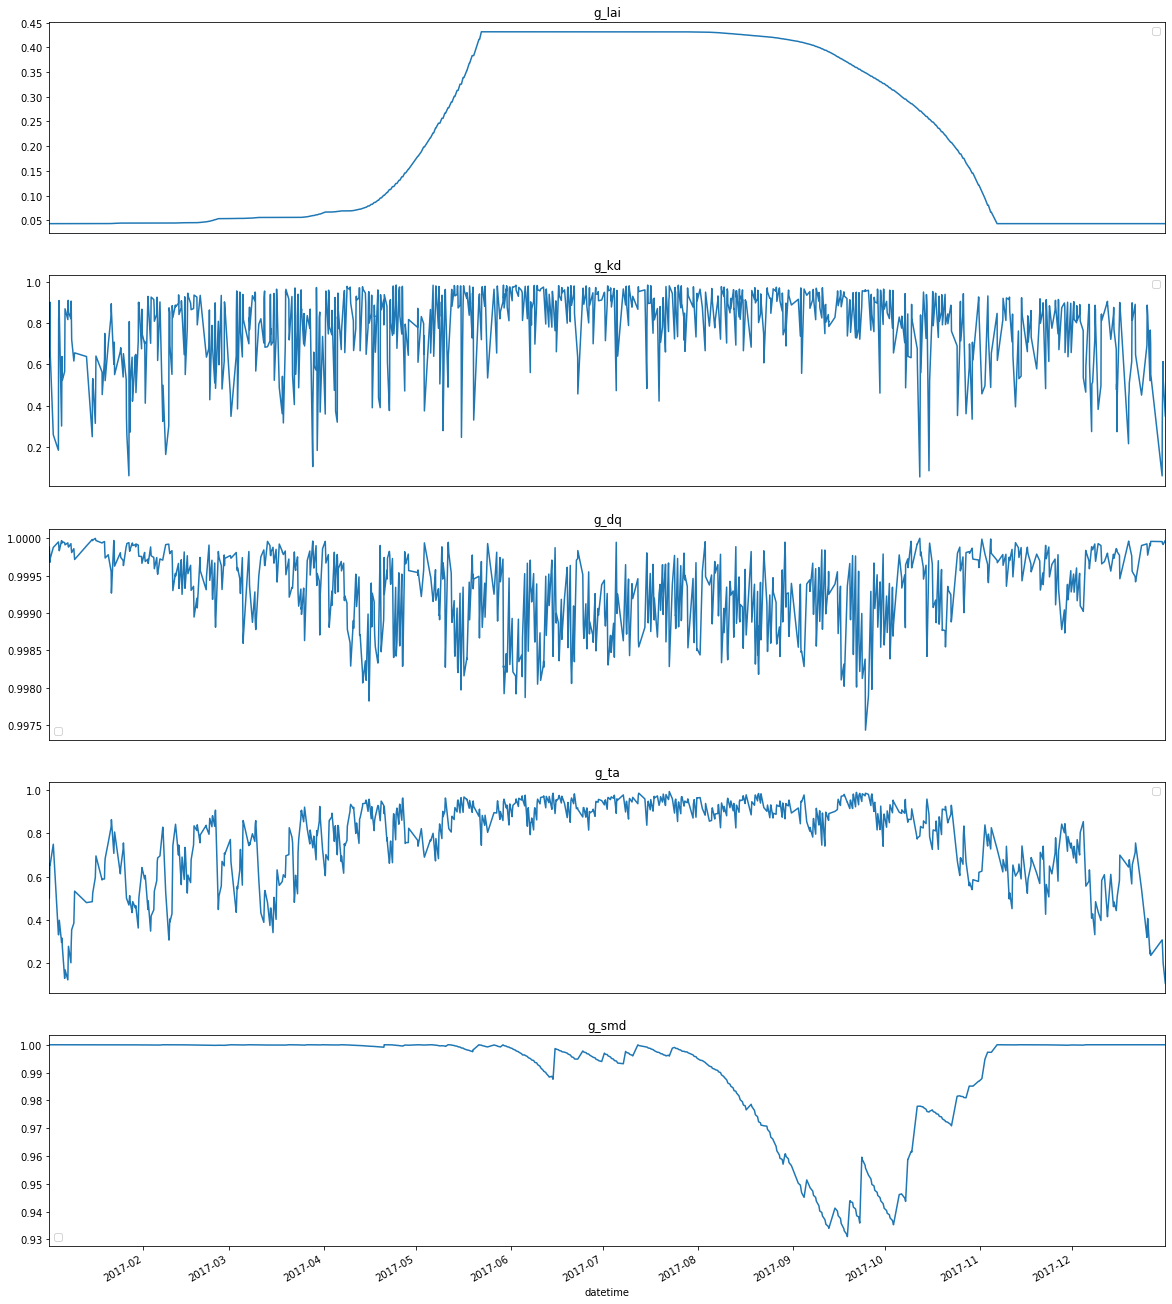

In [39]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    ax.legend('')
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')

## Running Supy with new g1-g6

2020-03-26 10:38:44,539 — SuPy — INFO — All cache cleared.
2020-03-26 10:38:45,412 — SuPy — INFO — All cache cleared.
2020-03-26 10:38:47,776 — SuPy — INFO — ====================
2020-03-26 10:38:47,776 — SuPy — INFO — Simulation period:
2020-03-26 10:38:47,777 — SuPy — INFO —   Start: 2016-12-31 23:05:00
2020-03-26 10:38:47,778 — SuPy — INFO —   End: 2017-12-31 23:00:00
2020-03-26 10:38:47,779 — SuPy — INFO — 
2020-03-26 10:38:47,780 — SuPy — INFO — No. of grids: 1
2020-03-26 10:38:47,782 — SuPy — INFO — SuPy is running in serial mode
2020-03-26 10:39:08,180 — SuPy — INFO — Execution time: 20.4 s
2020-03-26 10:39:08,181 — SuPy — INFO — ====================



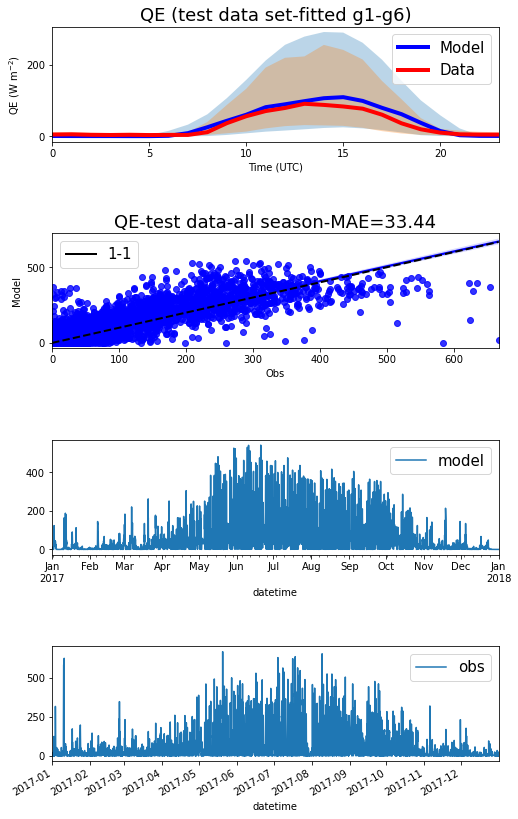

In [40]:
alpha=2.6 # need to be tuned iteratively
name='US-MMS'
year=year
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha)

In [41]:
g1=g1*alpha
g_max=g1*g_max
g1=1

In [42]:
g_max

37.03471400427182

## Creating the table for all sites here (if more than one site is tuned)

In [43]:
sites=['US-MMS']
g1_g6_all=pd.DataFrame(columns=['g1','g2','g3','g4','g5','g6'])

for s in sites:
    with open('outputs/g1-g6/'+s+'-g1-g6.pkl','rb') as f:
        g1_g6_all.loc[s,:]=pickle.load(f)
g1_g6_all  

,g1,g2,g3,g4,g5,g6
US-MMS,0.431336,104.34,0.633861,0.682953,35.25,0.0298504


## To test

### US-MMS-2016

2020-03-26 10:41:58,297 — SuPy — INFO — All cache cleared.
2020-03-26 10:41:59,122 — SuPy — INFO — All cache cleared.
2020-03-26 10:42:01,787 — SuPy — INFO — ====================
2020-03-26 10:42:01,789 — SuPy — INFO — Simulation period:
2020-03-26 10:42:01,791 — SuPy — INFO —   Start: 2015-12-31 23:05:00
2020-03-26 10:42:01,801 — SuPy — INFO —   End: 2016-12-31 23:00:00
2020-03-26 10:42:01,802 — SuPy — INFO — 
2020-03-26 10:42:01,807 — SuPy — INFO — No. of grids: 1
2020-03-26 10:42:01,810 — SuPy — INFO — SuPy is running in serial mode
2020-03-26 10:42:24,960 — SuPy — INFO — Execution time: 23.2 s
2020-03-26 10:42:24,961 — SuPy — INFO — ====================



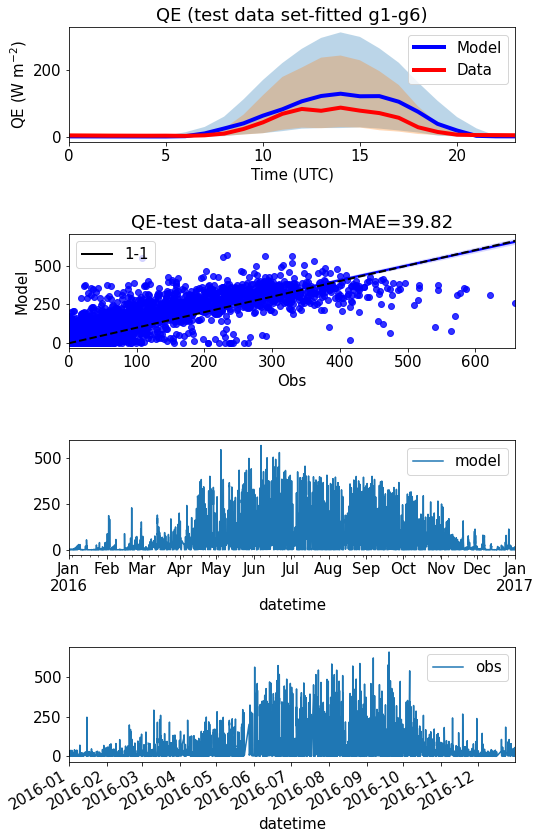

In [44]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56


name='US-MMS'
year=2016
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

### UMB-2014

2020-03-26 10:43:28,350 — SuPy — INFO — All cache cleared.
2020-03-26 10:43:29,145 — SuPy — INFO — All cache cleared.
2020-03-26 10:43:31,505 — SuPy — INFO — ====================
2020-03-26 10:43:31,506 — SuPy — INFO — Simulation period:
2020-03-26 10:43:31,506 — SuPy — INFO —   Start: 2013-12-31 23:05:00
2020-03-26 10:43:31,507 — SuPy — INFO —   End: 2014-12-31 23:00:00
2020-03-26 10:43:31,509 — SuPy — INFO — 
2020-03-26 10:43:31,511 — SuPy — INFO — No. of grids: 1
2020-03-26 10:43:31,512 — SuPy — INFO — SuPy is running in serial mode
2020-03-26 10:43:45,433 — SuPy — INFO — Execution time: 13.9 s
2020-03-26 10:43:45,434 — SuPy — INFO — ====================



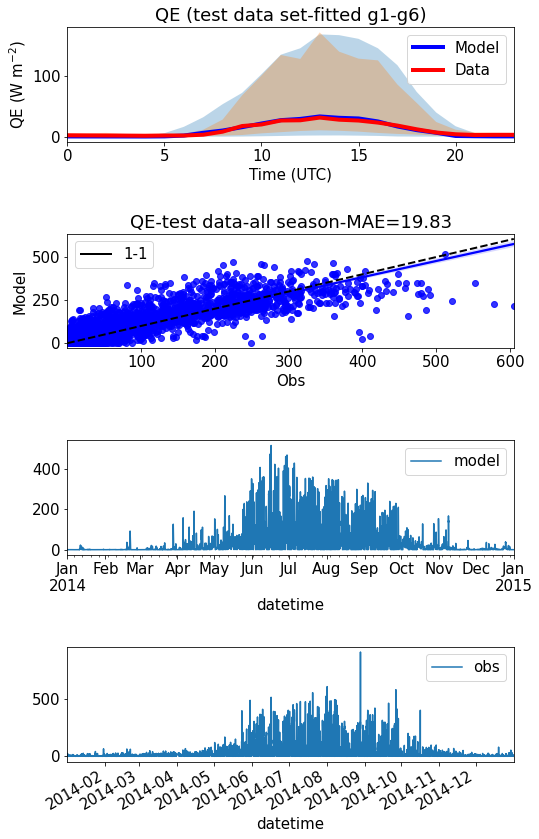

In [46]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56

name='US-UMB'
year=2014
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)

### US-Oho-2011

2020-03-26 10:43:49,647 — SuPy — INFO — All cache cleared.
2020-03-26 10:43:50,493 — SuPy — INFO — All cache cleared.
2020-03-26 10:43:53,625 — SuPy — INFO — ====================
2020-03-26 10:43:53,626 — SuPy — INFO — Simulation period:
2020-03-26 10:43:53,627 — SuPy — INFO —   Start: 2010-12-31 23:05:00
2020-03-26 10:43:53,628 — SuPy — INFO —   End: 2011-12-31 23:00:00
2020-03-26 10:43:53,629 — SuPy — INFO — 
2020-03-26 10:43:53,631 — SuPy — INFO — No. of grids: 1
2020-03-26 10:43:53,632 — SuPy — INFO — SuPy is running in serial mode
2020-03-26 10:44:11,821 — SuPy — INFO — Execution time: 18.2 s
2020-03-26 10:44:11,822 — SuPy — INFO — ====================



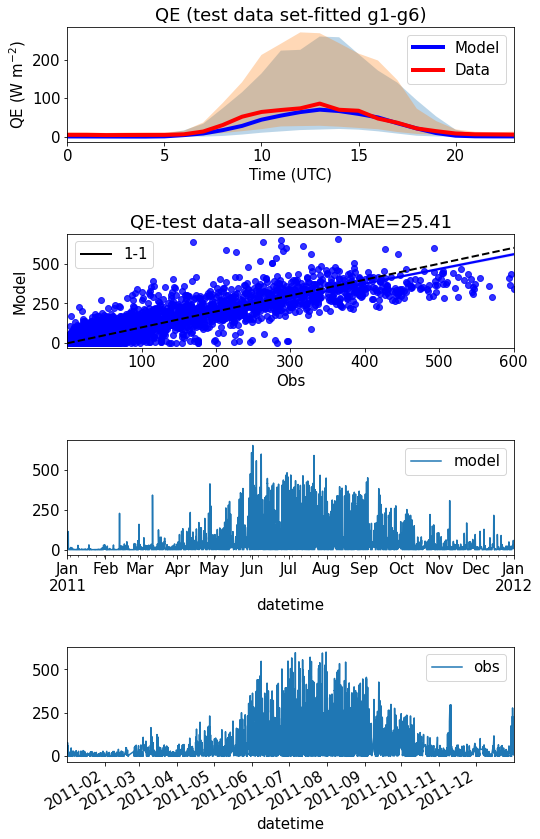

In [47]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['US-MMS',:].values
g_max=g_max
g1=1
s1=5.56

name='US-Oho'
year=2011
df_forcing= read_forcing(name,year)
gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year)